In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Load the dataset
df = pd.read_excel("/Users/elvinanosrati/Capstone/Amberd.xlsx")



In [74]:

# ✅ Step 1: Convert "Date" and "Time" into a single DateTime column
df["DateTime"] = pd.to_datetime(df["Date"].astype(str) + " " + df["Time"].astype(str), errors="coerce")

# ✅ Step 2: Set "DateTime" as the index
df.set_index("DateTime", inplace=True)

# ✅ Step 3: Drop the old "Date" and "Time" columns (optional)
df.drop(columns=["Date", "Time"], inplace=True)

# ✅ Step 4: Convert energy production column to numeric
df["Energy Production (kWh)"] = pd.to_numeric(df["Energy Production (kWh)"], errors="coerce")

# ✅ Step 5: Select only numeric data before resampling (EXCLUDE "Station")
df_numeric = df.select_dtypes(include=["number"])  # Only numeric columns
df_resampled = df_numeric.resample("D").mean()  # Resample to daily frequency

# ✅ Step 6: Interpolate missing values
df_resampled["Energy Production (kWh)"] = df_resampled["Energy Production (kWh)"].interpolate(method="linear")

# ✅ Step 7: Proceed with further analysis (STL, differencing, forecasting, etc.)
print(df_resampled.head())


            Hour Index  Energy Production (kWh)
DateTime                                       
2022-01-01        12.0               405.099130
2022-01-02        12.5               418.870278
2022-01-03        12.5               377.883333
2022-01-04        12.5               458.733333
2022-01-05        12.5               419.636389


In [75]:
# Count missing values per station
missing_values = df.isna().sum()
print(missing_values)

Hour Index                   0
Energy Production (kWh)    672
Station                      0
dtype: int64


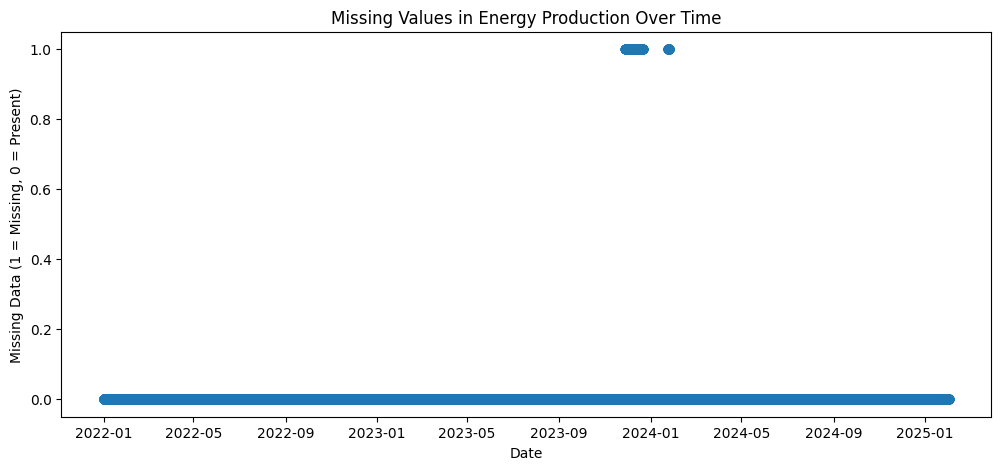

In [77]:

# Visualize missing data over time
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["Energy Production (kWh)"].isna(), marker="o", linestyle="")
plt.title("Missing Values in Energy Production Over Time")
plt.xlabel("Date")
plt.ylabel("Missing Data (1 = Missing, 0 = Present)")
plt.show()


In [78]:
# Count missing values per station
missing_values = df.isna().sum()
print(missing_values)

df.dropna(subset=["Energy Production (kWh)"], inplace=True)


Hour Index                   0
Energy Production (kWh)    672
Station                      0
dtype: int64


In [79]:
df["Energy Production (kWh)"].interpolate(method="linear", inplace=True)


/var/folders/x0/t4xvycdd6mz7b1y2rk0pl9mw0000gn/T/ipykernel_24826/3292389829.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Energy Production (kWh)"].interpolate(method="linear", inplace=True)


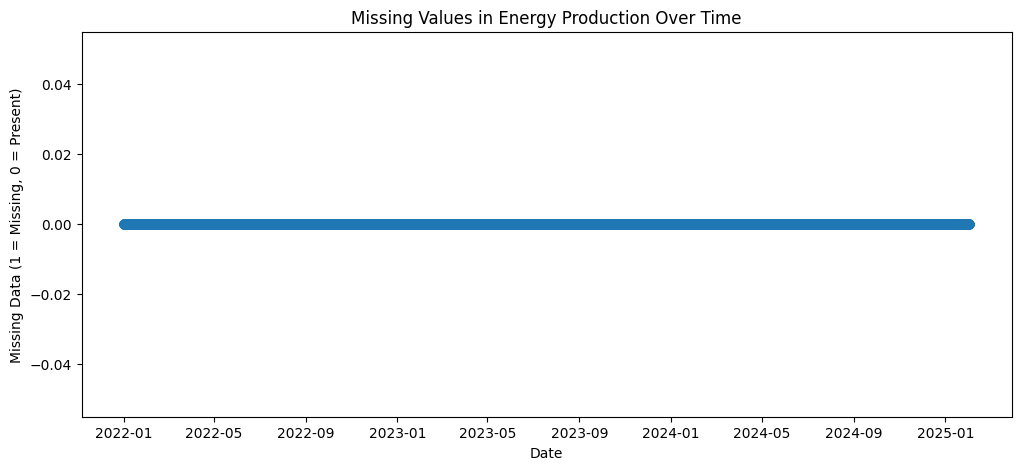

In [80]:
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["Energy Production (kWh)"].isna(), marker="o", linestyle="")
plt.title("Missing Values in Energy Production Over Time")
plt.xlabel("Date")
plt.ylabel("Missing Data (1 = Missing, 0 = Present)")
plt.show()


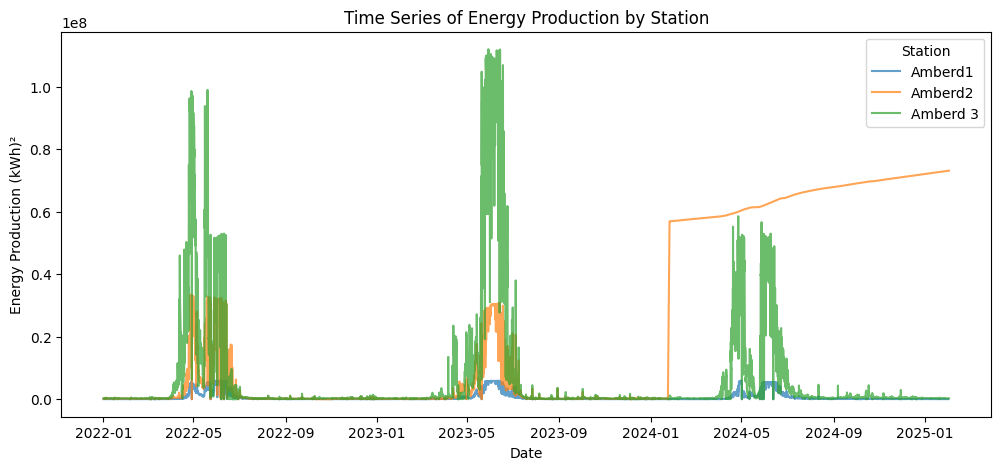

In [94]:
plt.figure(figsize=(12, 5))

sns.lineplot(data=df, x=df.index, y=df["Energy Production (kWh)"].fillna(0) ** 2, hue="Station", alpha=0.7)


plt.title("Time Series of Energy Production by Station")
plt.xlabel("Date")
plt.ylabel("Energy Production (kWh)²")  # Show squared units
plt.legend(title="Station")

plt.show()

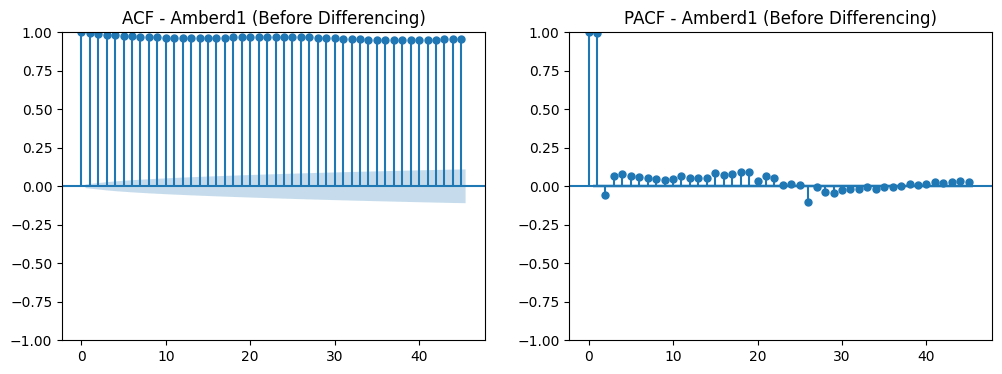

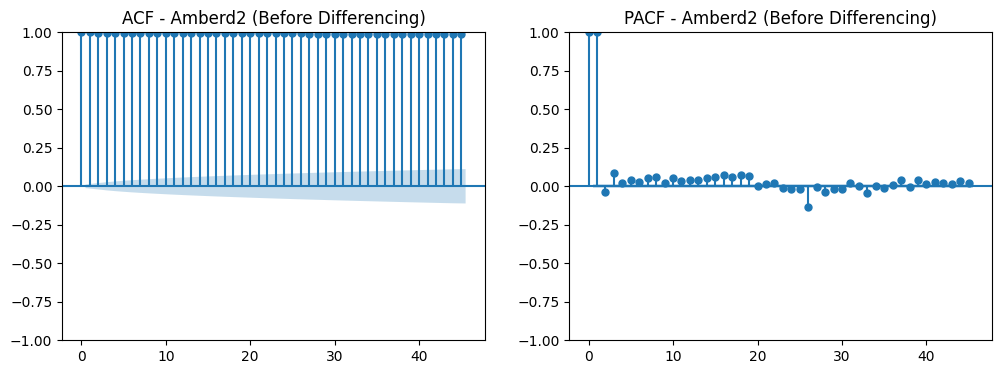

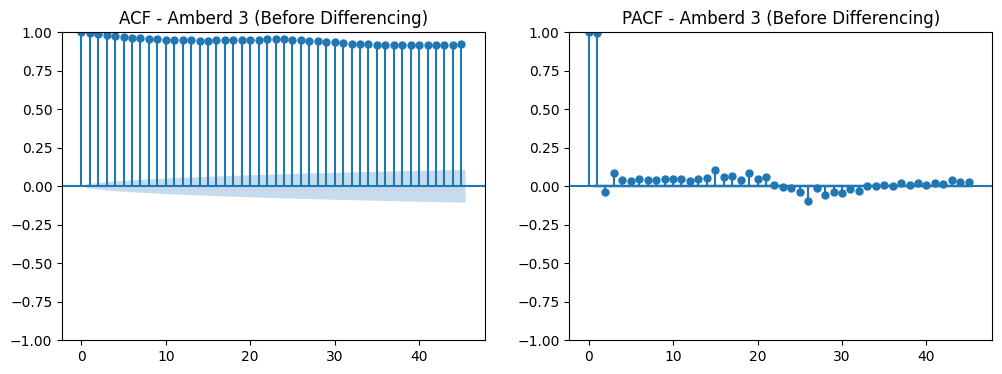

In [85]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

for station in df["Station"].unique():
    station_data = df.loc[df["Station"] == station, "Energy Production (kWh)"]

    station_data = station_data.dropna()
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(station_data, ax=axes[0], title=f"ACF - {station} (Before Differencing)")
    plot_pacf(station_data, ax=axes[1], title=f"PACF - {station} (Before Differencing)")

    plt.show()


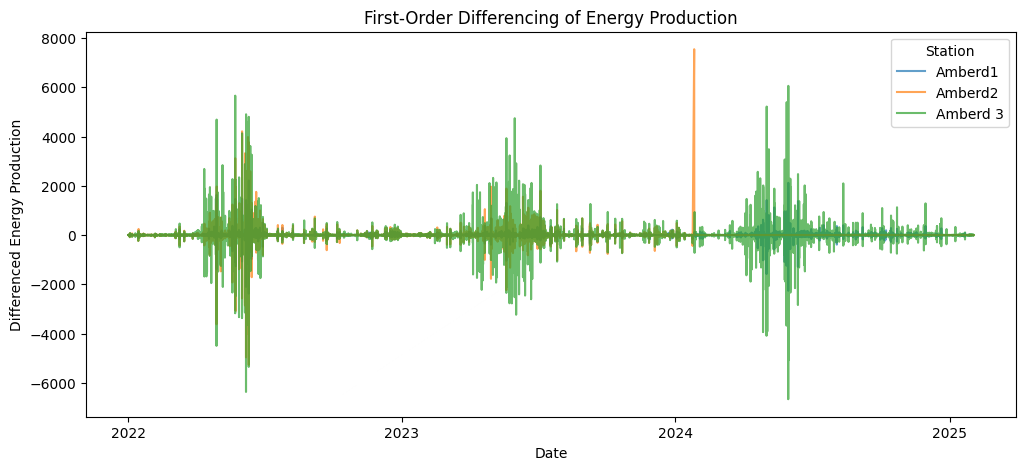

In [87]:
df["Diff_Production"] = df.groupby("Station")["Energy Production (kWh)"].diff()

df.dropna(subset=["Diff_Production"], inplace=True)

plt.figure(figsize=(12, 5))

sns.lineplot(data=df, x=df.index, y="Diff_Production", hue="Station", alpha=0.7)

plt.gca().xaxis.set_major_locator(mdates.YearLocator()) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))  

plt.title("First-Order Differencing of Energy Production")
plt.xlabel("Date")
plt.ylabel("Differenced Energy Production")
plt.legend(title="Station")

plt.show()




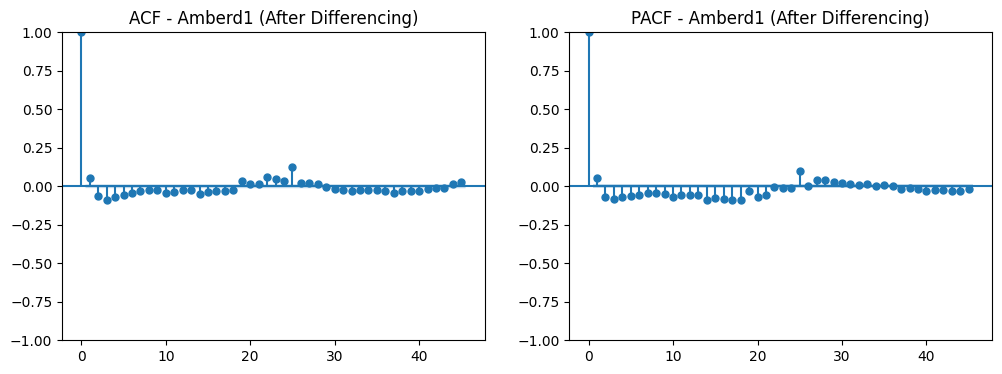

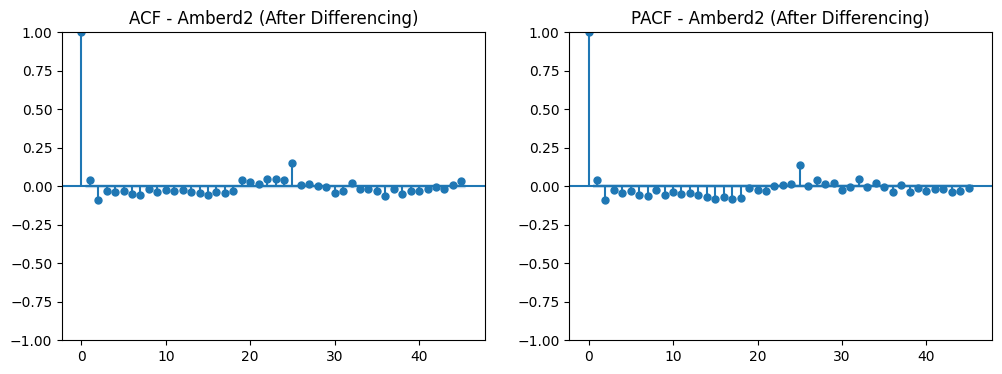

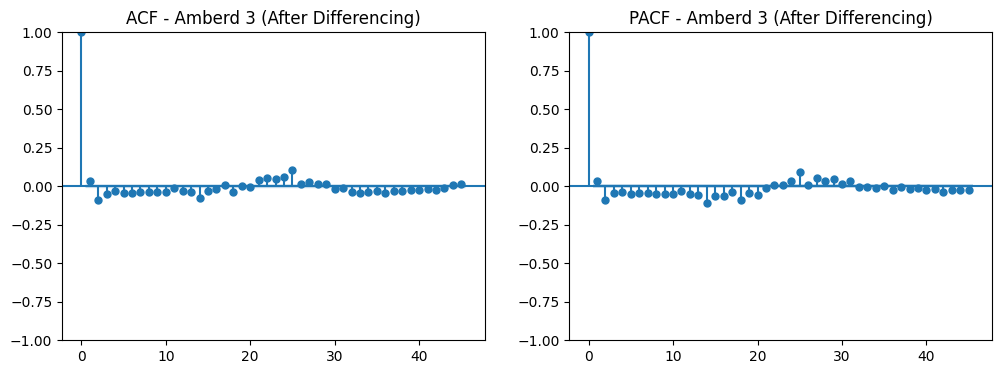

In [88]:
for station in df["Station"].unique():
    station_data = df.loc[df["Station"] == station, "Diff_Production"]

    station_data = station_data.dropna()

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(station_data, ax=axes[0], title=f"ACF - {station} (After Differencing)")
    plot_pacf(station_data, ax=axes[1], title=f"PACF - {station} (After Differencing)")

    plt.show()

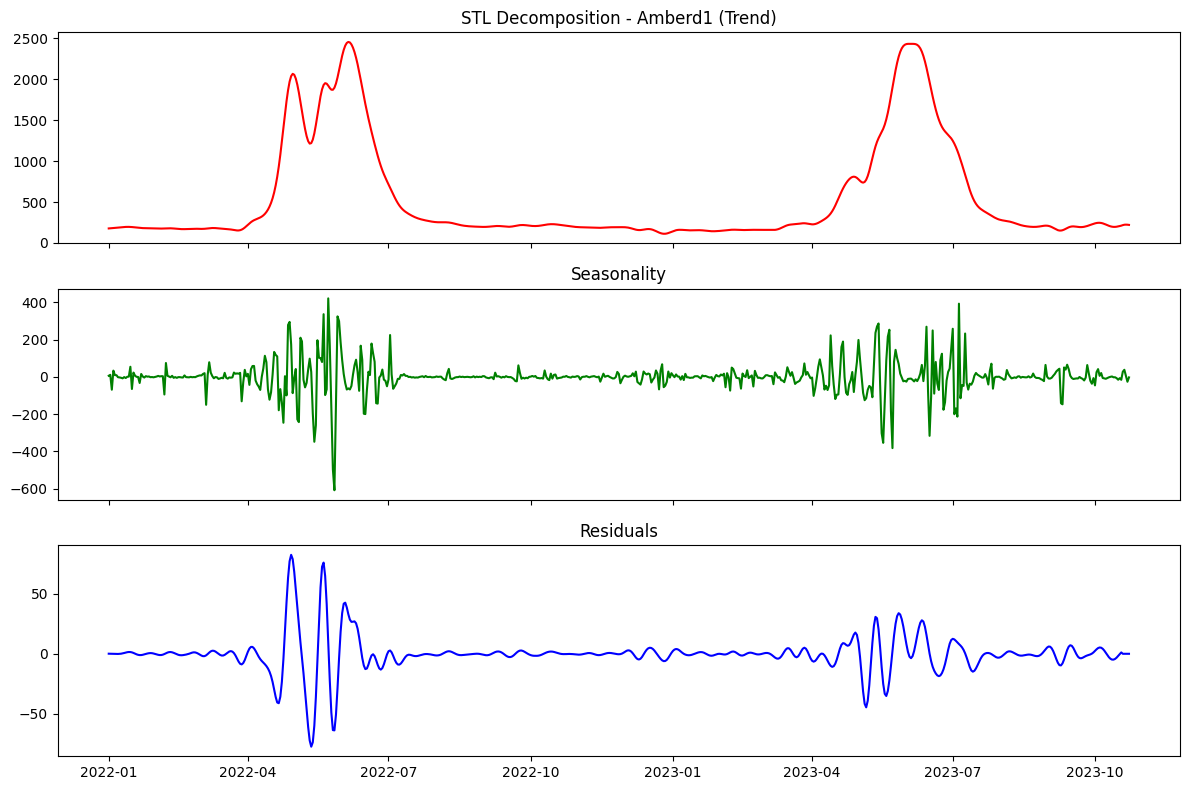

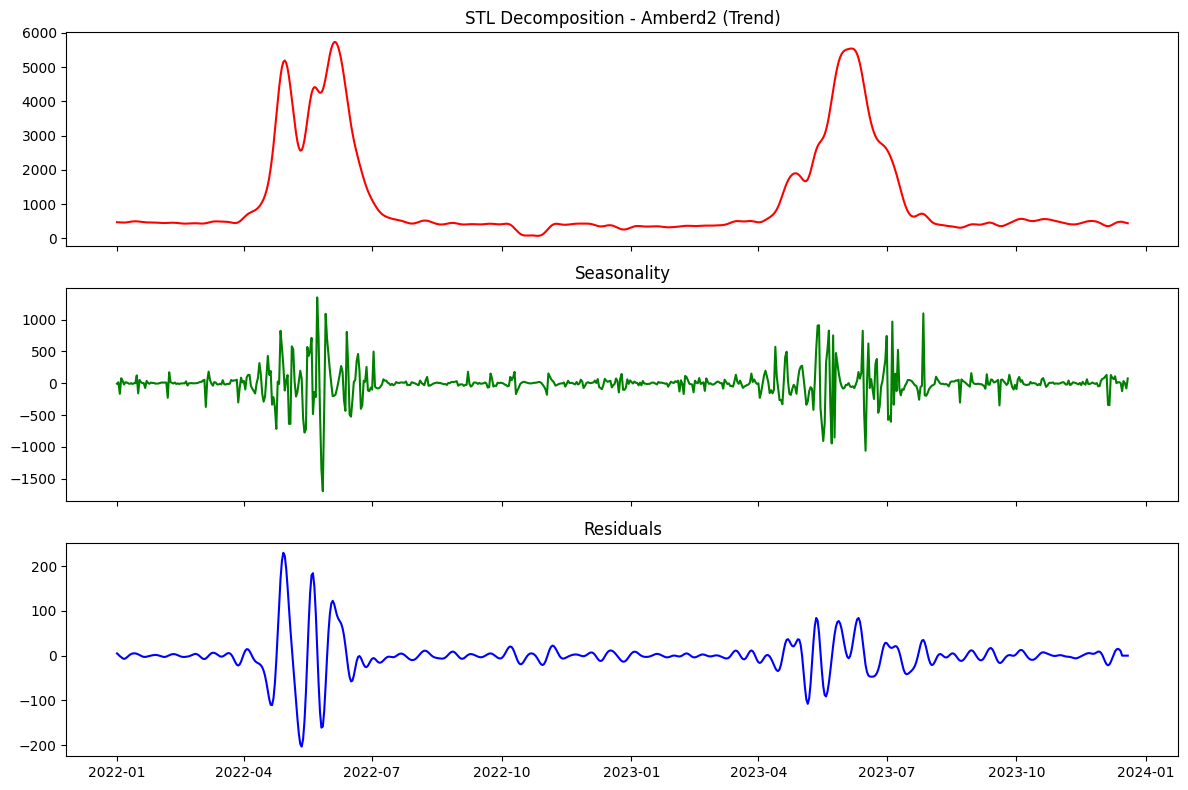

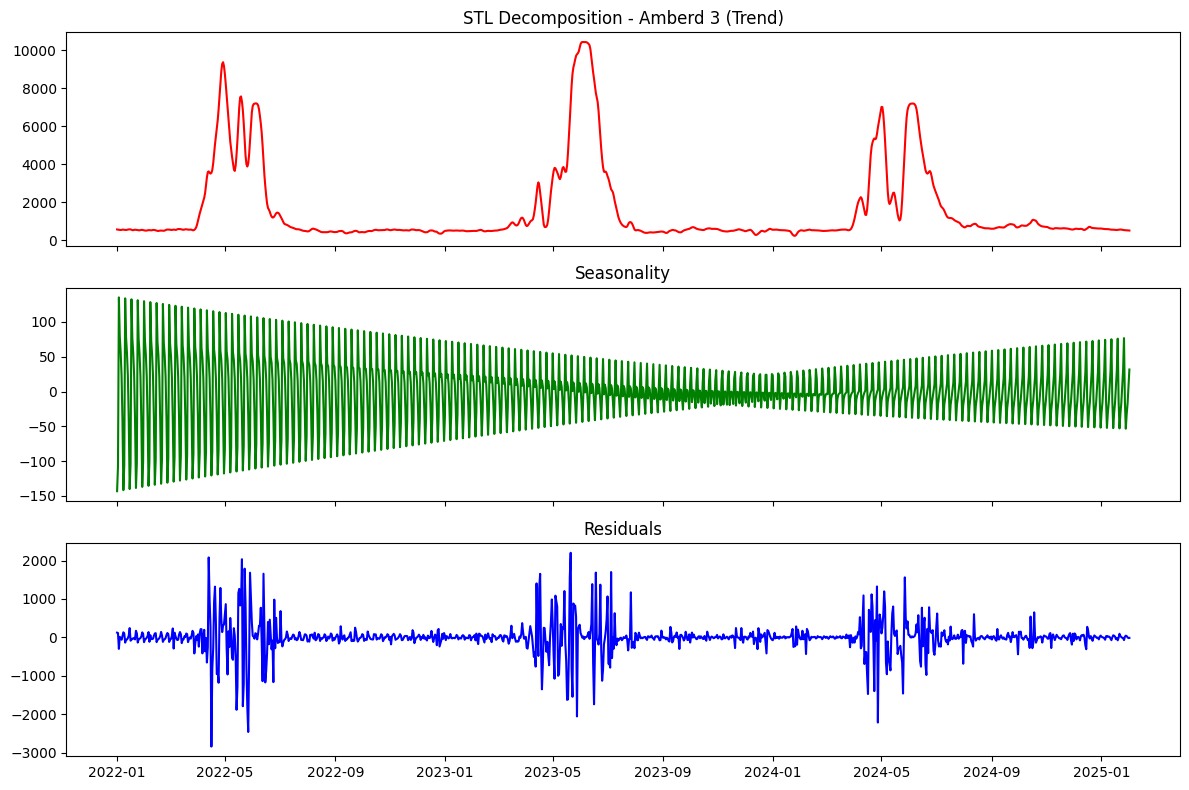

In [98]:
from statsmodels.tsa.seasonal import STL

for station in df["Station"].unique():
    station_data = df[df["Station"] == station]["Energy Production (kWh)"]

    # Ensure the data is sorted and has a proper frequency
    station_data = station_data.asfreq("D")

    # Apply STL Decomposition
    stl = STL(station_data, seasonal= 365)  
    result = stl.fit()

    # Plot the decomposition
    fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
    axes[0].plot(result.trend, label="Trend", color="red")
    axes[0].set_title(f"STL Decomposition - {station} (Trend)")

    axes[1].plot(result.seasonal, label="Seasonality", color="green")
    axes[1].set_title("Seasonality")

    axes[2].plot(result.resid, label="Residuals", color="blue")
    axes[2].set_title("Residuals")

    plt.tight_layout()
    plt.show()



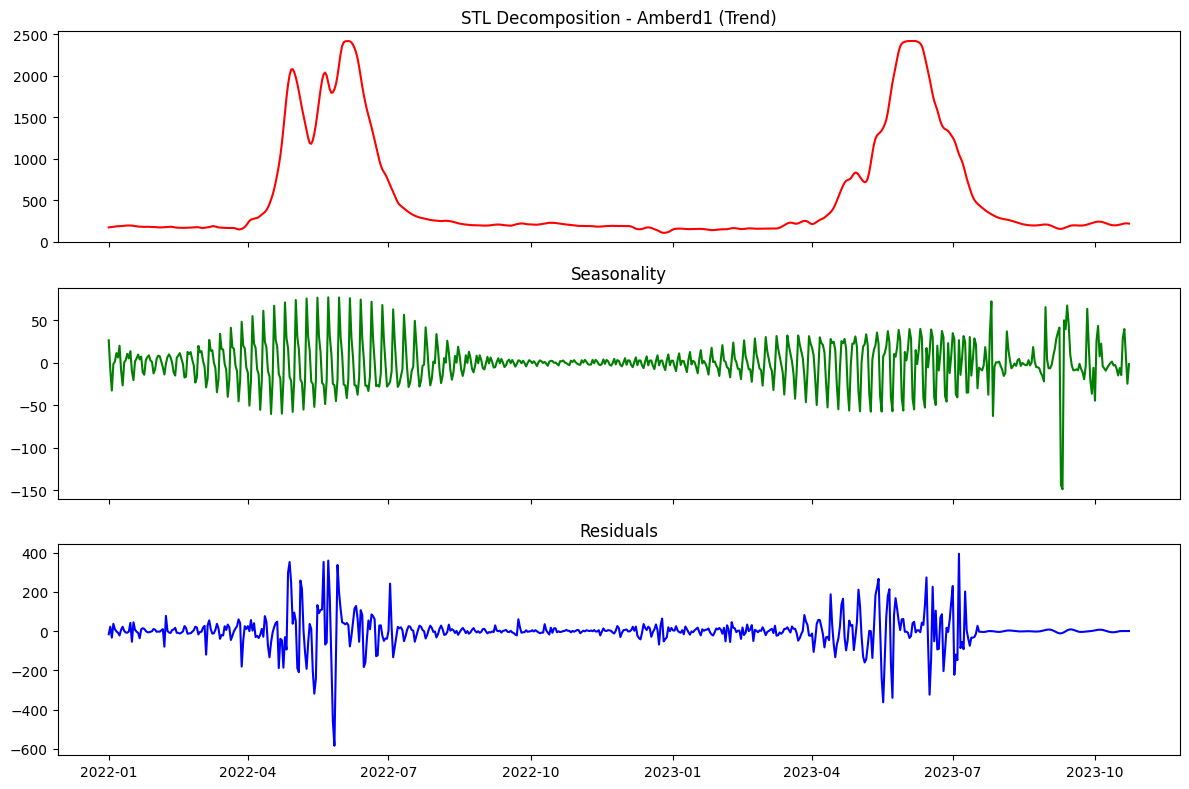

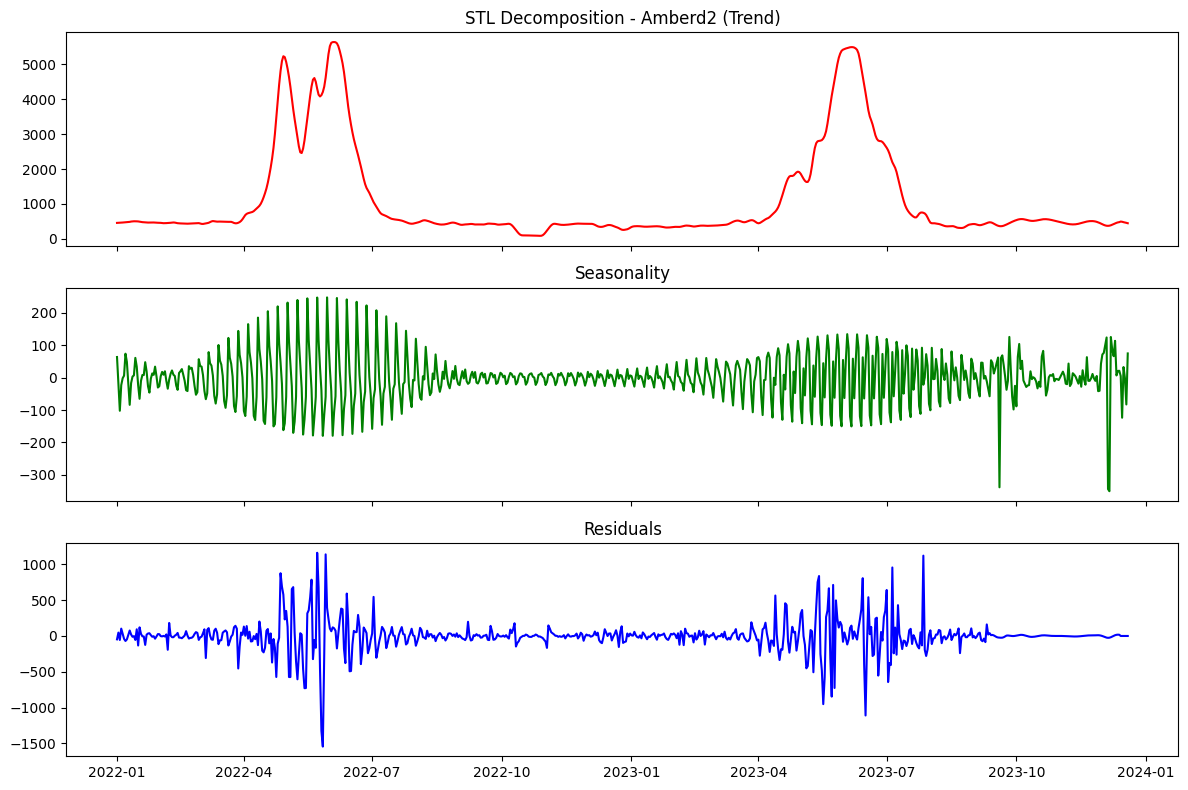

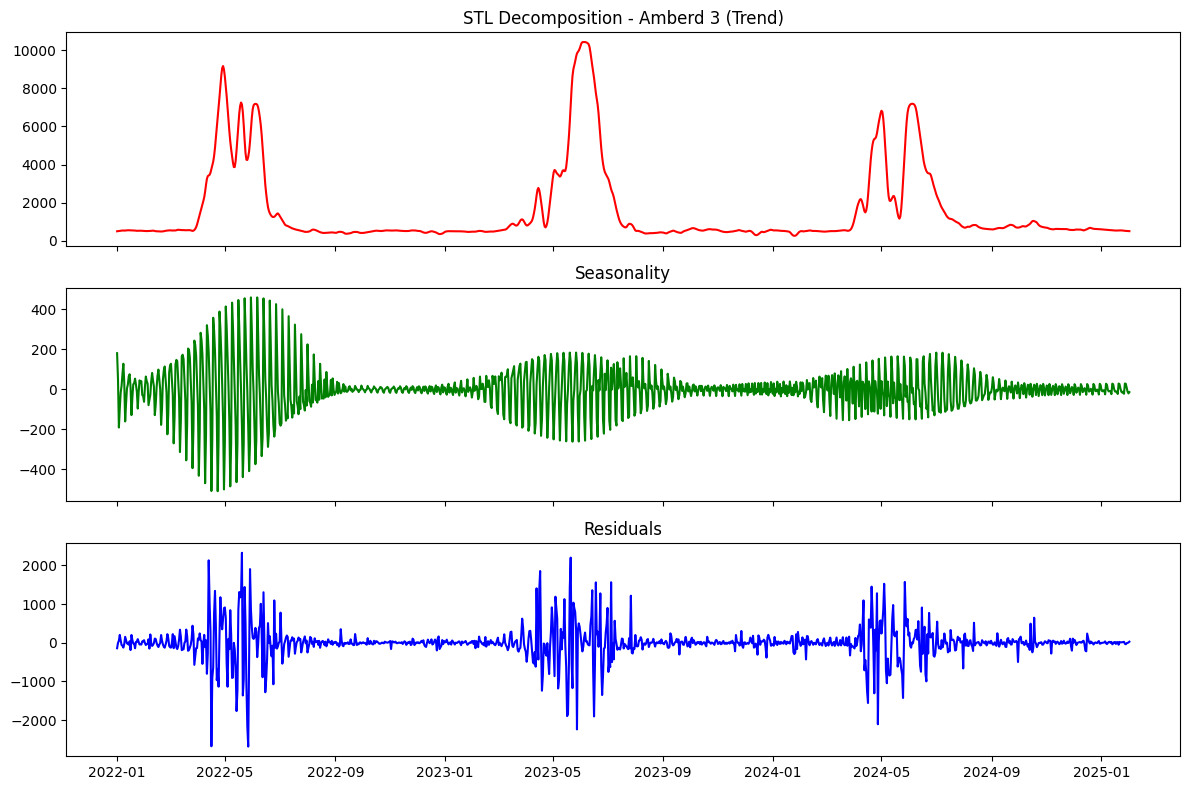

In [99]:
from statsmodels.tsa.seasonal import STL

for station in df["Station"].unique():
    station_data = df[df["Station"] == station]["Energy Production (kWh)"]

    # Ensure the data is sorted and has a proper frequency
    station_data = station_data.asfreq("D")

    # Apply STL Decomposition
    stl = STL(station_data, seasonal= 31)  
    result = stl.fit()

    # Plot the decomposition
    fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
    axes[0].plot(result.trend, label="Trend", color="red")
    axes[0].set_title(f"STL Decomposition - {station} (Trend)")

    axes[1].plot(result.seasonal, label="Seasonality", color="green")
    axes[1].set_title("Seasonality")

    axes[2].plot(result.resid, label="Residuals", color="blue")
    axes[2].set_title("Residuals")

    plt.tight_layout()
    plt.show()

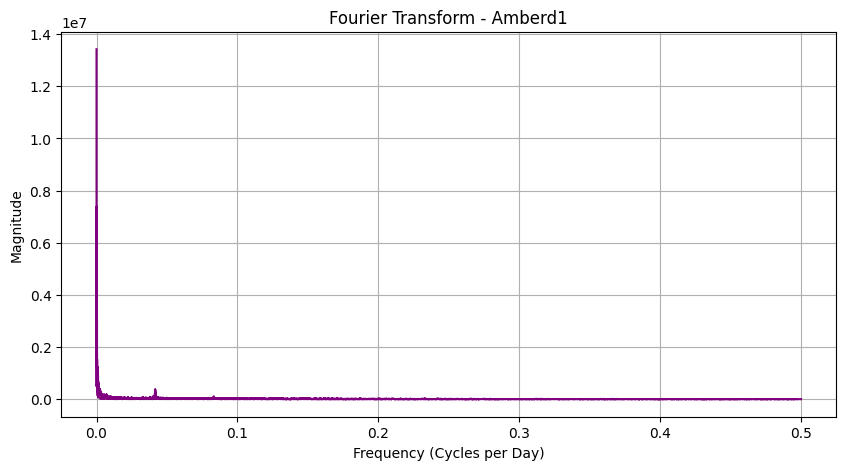

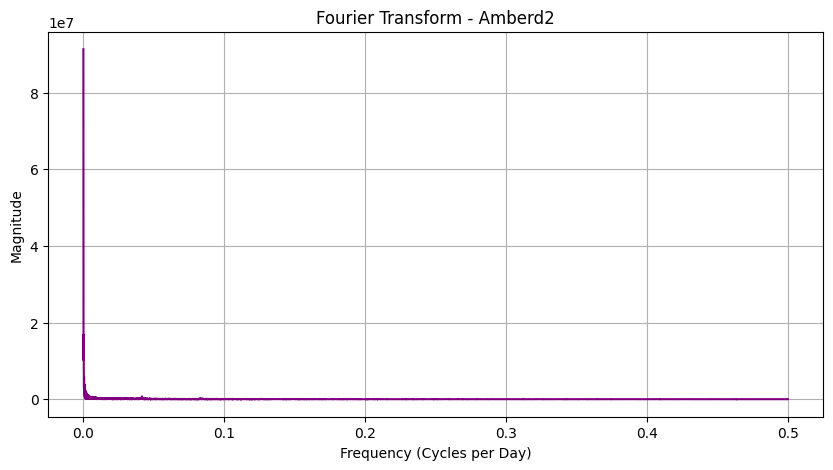

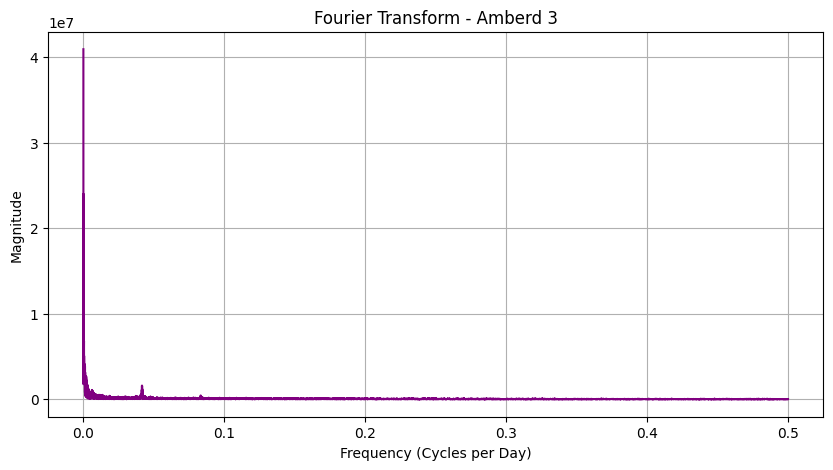

In [ ]:
import numpy as np
from scipy.fftpack import fft, fftfreq

for station in df["Station"].unique():
    station_data = df[df["Station"] == station]["Energy Production (kWh)"].dropna()  # Drop NaNs

    if station_data.empty:  # Check if the series is empty
        print(f"Skipping {station}, no valid data")
        continue  

    station_data = station_data.astype(float)  # Ensure numeric type

    N = len(station_data)
    T = 1  # Assuming daily frequency (1 day = 1 sample)

    # Apply FFT
    fft_result = fft(station_data.values)  # Use .values to avoid index issues
    frequencies = fftfreq(N, T)  

    # Only take the positive frequencies
    positive_freqs = frequencies[:N // 2]
    magnitude = np.abs(fft_result[:N // 2])

    # Plot FFT Spectrum
    plt.figure(figsize=(10, 5))
    plt.plot(positive_freqs, magnitude, color='purple')
    plt.title(f"Fourier Transform - {station}")
    plt.xlabel("Frequency (Cycles per Day)")
    plt.ylabel("Magnitude")
    plt.grid()
    plt.show()


In [ ]:
import pywt

for station in df["Station"].unique():
    station_data = df[df["Station"] == station]["Energy Production (kWh)"].dropna()
    
    # Apply Continuous Wavelet Transform (CWT)
    scales = np.arange(1, 128)  # Different frequency scales
    wavelet_name = 'cmor'  # Complex Morlet wavelet (good for time-frequency analysis)
    
    coefficients, frequencies = pywt.cwt(station_data, scales, wavelet_name)

    # Plot Wavelet Transform
    plt.figure(figsize=(12, 6))
    sns.heatmap(np.abs(coefficients), cmap="coolwarm", cbar=True)
    plt.title(f"Wavelet Transform - {station}")
    plt.xlabel("Time Index")
    plt.ylabel("Frequency Scale")
    plt.show()
